In [1]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import ttest_ind, ranksums, mannwhitneyu, kruskal
from statsmodels.stats.multitest import multipletests


# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
"""

Define some functions to plot with.

"""


def pairwise_ttest(df, group_column, value,
                   combinations=[],
                   correction=True):

    # get combos
    if len(combinations) == 0:
        order = sorted(set(df[group_column]))
        combinations = itertools.combinations(order, 2)
        combinations = list(combinations)
    pairwisedf = []
    max_order = {}
    for c1, c2 in combinations:
        # t-test
        t1 = df[df[group_column].isin([c1])][value].values
        t2 = df[df[group_column].isin([c2])][value].values
        t_res = ttest_ind(t1, t2)   
        # tdf
        t_res = pd.DataFrame(t_res,
                             ['test-stat','P'],
                             [c1 + ' vs. ' + c2])
        pairwisedf.append(t_res)
        max_= max(max(t1),max(t2))
        max_order[c1 + ' vs. ' + c2] = max_
    # merge
    pairwisedf = pd.concat(pairwisedf, axis=1).T
    # bonfer correct
    if correction:
        pairwisedf['P'] = pairwisedf['P'] * len(combinations)
    else:
        pairwisedf['P'] = pairwisedf['P'] * len(combinations)
    return pairwisedf, max_order


def swarmbox_plot(df, ax, y, x, order, palette='Set1', s_dot=10):
    
    # plotting.
    sns.swarmplot(y=y, x=x,
                  data=df,
                  palette=palette,
                  order=order,
                  ax=ax, s=s_dot)
    sns.boxplot(y=y, x=x,
                data=df,
                order=order,
                ax=ax,
                palette=palette)
    # patches
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # title etc ... 
    ax.set_xlabel('', fontsize=25)
    ax.set_ylabel('%s ($\\mathbf{\\mu}$M)' % y.capitalize(),
                  fontsize=22, color='black', weight='bold')
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    ax.tick_params(axis='x', colors='black')
    
    return ax

def swarmbox_plot_hue(df, ax, y, x, hue, order,
                      hue_order, palette='Set1'):
    
    # plotting.
    sns.swarmplot(y=y, x=x,
                  hue = hue,
                  dodge=True,
                  data=df,
                  hue_order=hue_order,
                  palette=palette,
                  order=order,
                  ax=ax, s=10)
    sns.boxplot(y=y, x=x,
                hue=hue,
                data=df,
                hue_order=hue_order,
                order=order,
                ax=ax,
                palette=palette)
    # patches
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # title etc ... 
    ax.set_xlabel('', fontsize=25)
    ax.set_ylabel('%s ($\\mu$M)' % y.capitalize(),
                  fontsize=22, color='black', weight='bold')
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    ax.tick_params(axis='x', colors='black')
    
    return ax


In [13]:
growth_exp = pd.read_csv('data/phenotype-measures/bacteroides_growth.csv')
growth_exp.columns = [x.split('hr')[0] for x in growth_exp.columns]
growth_exp['0'] = 0.056
growth_exp = growth_exp[['ID','0', '16', '24', '48']]
growth_exp.head(4)


,ID,0,16,24,48
0,CGM+acetate,0.056,0.057,0.057,0.056
1,CGM+acetate,0.056,0.214,0.258,0.215
2,CGM+acetate,0.056,0.055,0.055,0.054
3,CGM+acetate,0.056,0.056,0.056,0.057


In [85]:
growth_exp_stacked = pd.concat({k:df[['0', '16', '24', '48']].stack() for k, df in growth_exp.groupby('ID')}).reset_index().drop(['level_1'], axis=1)
growth_exp_stacked.columns = ['condition', 'time', 'OD600']
growth_exp_stacked['time'] = growth_exp_stacked['time'].astype(int)
growth_exp_stacked['OD600'] -= 0.056
growth_exp_stacked.loc[growth_exp_stacked['OD600'] < 0, 'OD600'] = 0
growth_exp_stacked['condition'] = [x.replace('met', 'Methionine').replace('CGM+', '').replace('0.2%', '').replace('+', ' + ').title()
                                   for x in growth_exp_stacked.condition]

growth_exp_stacked.head(5)


,condition,time,OD600
0,Glucose,0,0.000
1,Glucose,16,0.402
2,Glucose,24,0.554
3,Glucose,48,0.309
4,Glucose,0,0.000


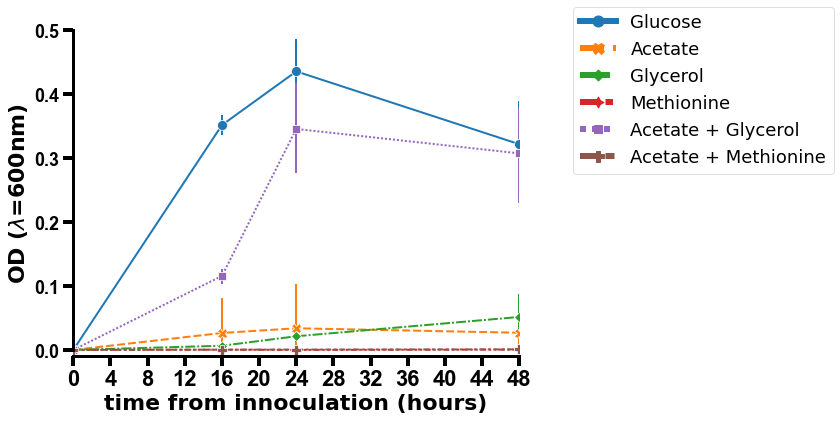

In [136]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 10

fig, ax = plt.subplots(figsize=(8, 6))

pal_= {'Acetate':'#e31a1c',
     'Acetate + Glycerol':'#ff7f00',
     'Acetate + Methionine':'#fb9a99',
     'Glucose':'#1f78b4',
     'Glycerol':'#ff7f00',
     'Methionine':'#33a02c'}
hue_order = ['Glucose', 'Acetate', 'Glycerol',
             'Methionine', 'Acetate + Glycerol','Acetate + Methionine']
hue_linestyles = ['-', '-', '--', '-', '--', '-']
hue_markstyles = ['o', 'o', 'x', 'o', 'x', 'o']


g = sns.lineplot(x='time', y='OD600', hue='condition', style="condition",
                 data=growth_exp_stacked,
                 hue_order=hue_order,
                 err_style="bars", 
                 markers=True,
                 dashes=True,
                 ax=ax, ci=95,
                 palette='tab10')

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
# remove all grids, backrounds etc ...
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    #tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(18)
    
    

ax.set_ylim(-0.01, 0.5)
ax.spines['left'].set_bounds(0, 0.5)

ax.set_xlim(-0.05, 48)
ax.spines['bottom'].set_bounds(0, 48)

ax.set_ylabel('OD ($\\lambda$=600nm)',           
              fontsize=22, color='black', weight='bold')

ax.set_xlabel('time from innoculation (hours)', 
              fontsize=22, color='black', weight='bold')

import matplotlib.ticker as ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))


# add a legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], labels[:],
            prop={'size':18}, loc=2, 
            bbox_to_anchor=(1.1, 1.1),
            fancybox=True, framealpha=0.8,ncol=1
            , markerscale=1.1, facecolor="white")
for line in legend.get_lines():
    line.set_linewidth(6.0)
    
plt.show()

## First experiment

In [28]:
# import data
measures = pd.read_excel('data/phenotype-measures/revisons-scfa.xlsx', sheet_name='experiment_1', index_col=0)
measures['treatment'] = [x.replace('ethanol','EtOH').replace('control','Ctrl') for x in measures.treatment]
measures.head(3)


,treatment,acetate,propionate,isobutyrate,butyrate,isovalerate,valerate,caproate,heptanoate
SampleID,,,,,,,,,
324,Ctrl,594.087547,9.062149,6.282282,2.094385,0.502333,1.121331,6.975375,2.527264
325,Ctrl,689.767898,9.600893,6.306705,1.805961,0.650442,1.240808,6.925333,2.740604
327,Ctrl,565.626022,10.137242,6.840134,2.040249,0.741198,1.620925,8.689590,2.111960


In [29]:
# prepare to plot
acetatedf = measures[['acetate','treatment']]



# prepare to plot
sfcadf = measures[list(measures.columns[1:]) + ['treatment']]
sfcadf = pd.melt(sfcadf, id_vars=['treatment']) 


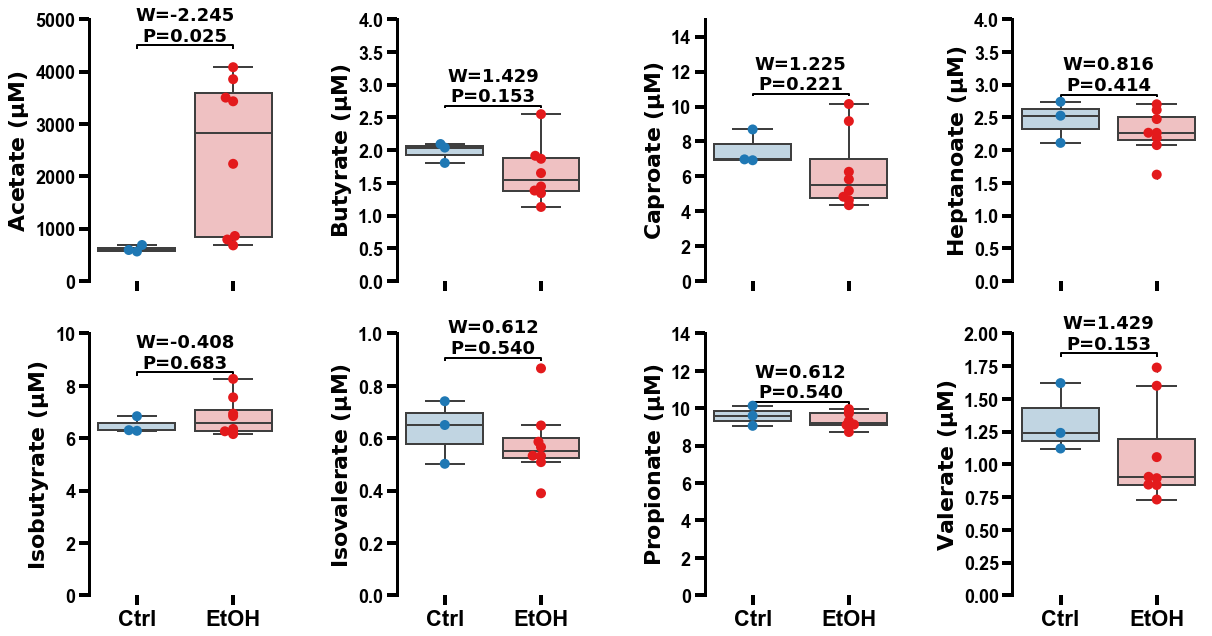

In [30]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 10

n_comapre = len(set(sfcadf.variable))

fig, axn = plt.subplots(2, 4,
                       figsize=(5 * 4, 5 * 2),
                       sharex=True)

order = ['Ctrl','EtOH']
pallette = {'Ctrl':'#1f78b4',
            'EtOH':'#e31a1c'}
treatment_col = 'treatment'
pvals = []
ylims = {'acetate':(0,5000), 'isobutyrate':(0,10),'caproate':(0,15),'heptanoate':(0,4),
         'butyrate':(0,4), 'isovalerate':(0,1), 'propionate':(0,14), 'valerate':(0,2)}

for ax, (variable_col, dfplot) in zip(axn.flatten(), sfcadf.groupby('variable')):
    
    # fix
    dfplot = dfplot.drop('variable', axis=1)
    dfplot = dfplot.rename({'value': variable_col}, axis=1)

    # plot
    ax = swarmbox_plot(dfplot, ax,
                       variable_col,
                       treatment_col,
                       order,
                       palette=pallette)
    # get stats 
    #statdf, max_order = pairwise_ttest(dfplot,
    #                                   treatment_col,
    #                                   variable_col)
    # get stats
    max_order = {'Ctrl vs. EtOH': dfplot[variable_col].max() + dfplot[variable_col].std() / 4}
    statdf = pd.DataFrame(ranksums(dfplot[dfplot.treatment == 'Ctrl'][variable_col].values,
                                       dfplot[dfplot.treatment == 'EtOH'][variable_col].values),
                          ['test-stat', 'P'], ['Ctrl vs. EtOH']).T
    
    # annotate by order
    i1 = 0 
    c1 = order[0]
    for i2, c2 in enumerate(order[1:]):
        # annot x-axis
        x1, x2 = i1, (i2 + 1)
        # get label
        label_ = c1 + ' vs. ' + c2
        if label_ not in statdf.index:
            label_ = c2 + ' vs. ' + c1
        # get stat
        p_ = statdf.loc[label_, 'P']
        pvals.append(p_)
        t_ = statdf.loc[label_, 'test-stat']
        p_ = 'W=%.3f\nP=%.3f' % (t_, p_)
        # heights
        y, h, col = max_order[label_], max_order[label_]/100, 'k'
        # plot
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
        ax.text((x1+x2)*.5, y+h, p_,
                ha='center', va='bottom',
                color=col, fontsize=18, weight='bold')  

    for sp_i in ax.spines.values():
        sp_i.set_linewidth(2)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.set_ylim(0, ylims[variable_col][1])
    ax.spines['left'].set_bounds(0, ylims[variable_col][1])

    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')

    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    """ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")"""
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        #tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(18)
        

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.6   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


# save the figure to file
plt.savefig('results/figures/scfas.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()



In [33]:
sfcadf[sfcadf.variable == 'acetate'].groupby('treatment').mean()

,value
treatment,
Ctrl,616.493822
EtOH,2432.261800


## Second Experiment

In [18]:
# dose
dosedf = pd.read_csv('data/phenotype-measures/gta-dose-time.csv')
dosedf.index = 'sample-' + dosedf.index.astype(str)
# mouse measures
phenodf = pd.read_csv('data/phenotype-measures/gta-treatment-phenotype-measurements.csv')
phenodf.index = 'sample-' + phenodf.index.astype(str)
phenodf = phenodf[phenodf['sick-infusion'] != 1]
phenodf['Tx1'] = [x.replace('_','-').replace('Alcohol','Ethanol') for x in phenodf['Tx1']]

# import SCFA data
measures = pd.read_excel('data/phenotype-measures/revisons-scfa.xlsx', sheet_name='experiment_2_rev', index_col=0)
measures['treatment'] = [x.replace('_','-').replace('Alcohol','Ethanol') for x in measures['treatment']]
# prepare to plot
sfcadf = measures[list(measures.columns[1:]) + ['treatment']]
sfcadf = pd.melt(sfcadf, id_vars=['treatment']) 
sfcadf.head(5)


,treatment,variable,value
0,Glucose-Glycerol,acetate,177.811585
1,Glucose-Glycerol,acetate,227.524836
2,Glucose-Glycerol,acetate,193.073952
3,Glucose-Glycerol,acetate,124.534672
4,Glucose-Glycerol,acetate,127.722367


In [19]:
phenodf.shape

(29, 11)

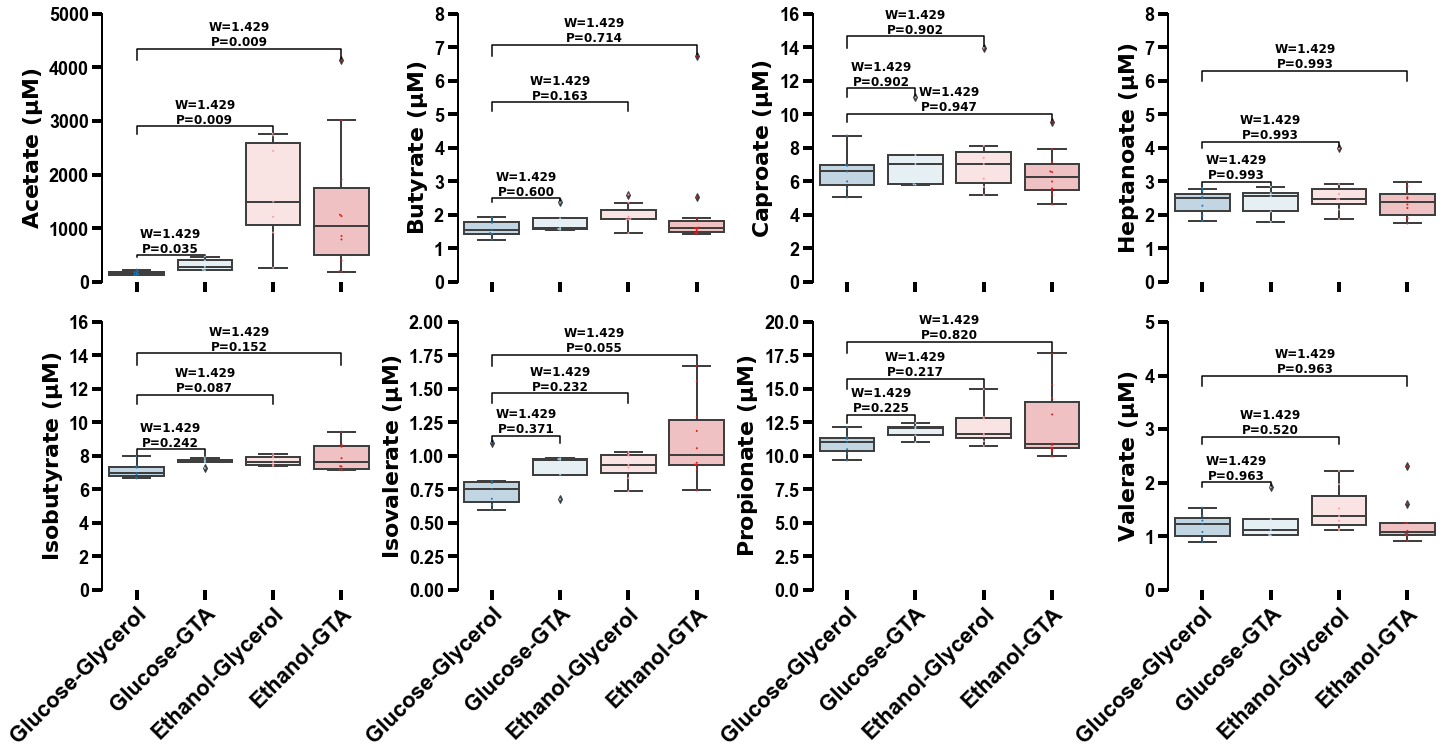

In [26]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 10

n_comapre = len(set(sfcadf.variable))

fig, axn = plt.subplots(2, 4,
                       figsize=(6 * 4, 5 * 2),
                       sharex=True)

# plot
order = ['Glucose-Glycerol', 'Glucose-GTA',
         'Ethanol-Glycerol', 'Ethanol-GTA']
pallette = {'Glucose-Glycerol':'#1f78b4',
         'Glucose-GTA':'#a6cee3',
         'Ethanol-Glycerol':'#fb9a99',
         'Ethanol-GTA':'#e31a1c'}
treatment_col = 'treatment'
pvals = []
ylims = {'acetate':(0,5000), 'isobutyrate':(0,16),'caproate':(0,16),'heptanoate':(0,8),
         'butyrate':(0,8), 'isovalerate':(0,2), 'propionate':(0,20), 'valerate':(0,5)}

for ax, (variable_col, dfplot) in zip(axn.flatten(), sfcadf.groupby('variable')):
    
    # fix
    dfplot = dfplot.drop('variable', axis=1)
    dfplot = dfplot.rename({'value': variable_col}, axis=1)
    

    ax = swarmbox_plot(dfplot, ax,
                        variable_col,
                       treatment_col,
                       order,
                       palette=pallette, s_dot=2)
    # get stats
    compare_ = [('Glucose-GTA','Glucose-Glycerol'),
                ('Ethanol-Glycerol','Glucose-Glycerol'),
                ('Glucose-GTA','Ethanol-Glycerol'),
                ('Ethanol-GTA','Glucose-Glycerol'),
                ('Ethanol-GTA','Ethanol-Glycerol'),]

    statdf = pd.concat([pd.DataFrame(ranksums(dfplot[dfplot.treatment == c1][variable_col].values,
                                              dfplot[dfplot.treatment == c2][variable_col].values),
                                     ['test-stat', 'P'], ['%s vs. %s' % (c1, c2)]).T
                        for c1, c2 in compare_])
    statdf['P'] = multipletests(statdf['P'].values)[1]
    
    
    max_order = {'%s vs. %s' % (c1, c2):dfplot[dfplot.treatment.isin([c1, c2])][variable_col].max()
                 for i, (c1, c2) in enumerate(compare_)}
    if variable_col == 'butyrate':
        max_order['Ethanol-Glycerol vs. Glucose-Glycerol'] += 2.5
    elif variable_col == 'heptanoate':
        max_order['Ethanol-GTA vs. Glucose-Glycerol'] += 3
    elif variable_col == 'isobutyrate':
        max_order['Ethanol-Glycerol vs. Glucose-Glycerol'] += 3
        max_order['Ethanol-GTA vs. Glucose-Glycerol'] += 4
    elif variable_col == 'isovalerate':
        max_order['Ethanol-Glycerol vs. Glucose-Glycerol'] += 0.3
    elif variable_col == 'valerate':  
        max_order['Ethanol-Glycerol vs. Glucose-Glycerol'] += 0.5
        max_order['Ethanol-GTA vs. Glucose-Glycerol'] += 1.5 

    # annotate by order
    i1 = 0 
    c1 = order[0]
    for i2, c2 in enumerate(order[1:]):
        # annot x-axis
        x1, x2 = i1, (i2 + 1)
        # get label
        label_ = c1 + ' vs. ' + c2
        if label_ not in statdf.index:
            label_ = c2 + ' vs. ' + c1
        # get stat
        p_ = statdf.loc[label_, 'P']
        p_ = 'W=%.3f\nP=%.3f' % (t_, p_)
        # heights
        y, h, col = max_order[label_], max_order[label_]/20, 'k'
        # plot
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        ax.text((x1+x2)*.5, y+h, p_,
                ha='center', va='bottom',
                color=col, fontsize=12, weight='bold')

    # relabel
    ax.set_ylabel('%s ($\\mathbf{\\mu}$M)' % variable_col.capitalize(),
                  fontsize=22, color='black', weight='bold')
    ax.tick_params(axis='x', rotation=90)

    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(18)

    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)

    for sp_i in ax.spines.values():
        sp_i.set_linewidth(2)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.set_ylim(0, ylims[variable_col][1])
    ax.spines['left'].set_bounds(0, ylims[variable_col][1])


left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.15  # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


# save the figure to file
plt.savefig('results/figures/scfas-experiment2.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

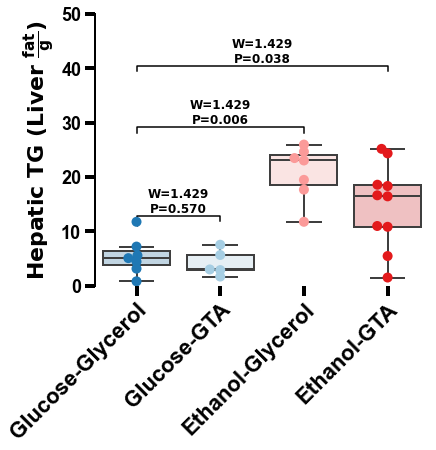

In [140]:

plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 12


fig, ax = plt.subplots(1,1, figsize=(6,5))

# plot
x_axis = 'HEPATIC TG (mg fat/g liver)'
phenodf['treatment'] = phenodf['Tx1'] + '-' + phenodf['Tx2'] 
order = ['Glucose-Glycerol', 'Glucose-GTA',
         'Ethanol-Glycerol', 'Ethanol-GTA']
pallette = {'Glucose-Glycerol':'#1f78b4',
         'Glucose-GTA':'#a6cee3',
         'Ethanol-Glycerol':'#fb9a99',
         'Ethanol-GTA':'#e31a1c'}


ax = swarmbox_plot(phenodf, ax,
                    x_axis,
                   'treatment',
                   order,
                   palette=pallette)
# get stats
compare_ = [('Glucose-GTA','Glucose-Glycerol'),
            ('Ethanol-Glycerol','Glucose-Glycerol'),
            ('Ethanol-GTA','Glucose-Glycerol')]

statdf = pd.concat([pd.DataFrame(ranksums(phenodf[phenodf.treatment == c1][x_axis].values,
                                          phenodf[phenodf.treatment == c2][x_axis].values),
                                 ['test-stat', 'P'], ['%s vs. %s' % (c1, c2)]).T
                    for c1, c2 in compare_])
statdf['P'] = multipletests(statdf['P'].values)[1]
max_order = {'%s vs. %s' % (c1, c2):phenodf[phenodf.treatment.isin([c1, c2])][x_axis].max() + (i*7)
             for i, (c1, c2) in enumerate(compare_)}
max_order['Ethanol-Glycerol vs. Glucose-Glycerol'] -= 5

# annotate by order
i1 = 0 
c1 = order[0]
for i2, c2 in enumerate(order[1:]):
    # annot x-axis
    x1, x2 = i1, (i2 + 1)
    # get label
    label_ = c1 + ' vs. ' + c2
    if label_ not in statdf.index:
        label_ = c2 + ' vs. ' + c1
    # get stat
    p_ = statdf.loc[label_, 'P']
    p_ = 'W=%.3f\nP=%.3f' % (t_, p_)
    # heights
    y, h, col = max_order[label_] + .1 * (i2+1), 1, 'k'
    # plot
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            color=col, fontsize=12, weight='bold')
    
# relabel
ax.set_ylabel('Hepatic TG (Liver $\\frac{\\mathbf{fat}}{\\mathbf{g}}$)',
              fontsize=22,
              color='black')
ax.tick_params(axis='x', rotation=90)

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(18)
    
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)

for sp_i in ax.spines.values():
    sp_i.set_linewidth(2)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.spines['left'].set_bounds(0, 50)
ax.set_ylim(0, 50)



# save the figure to file
plt.savefig('results/figures/HEPATIC-GTA.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()



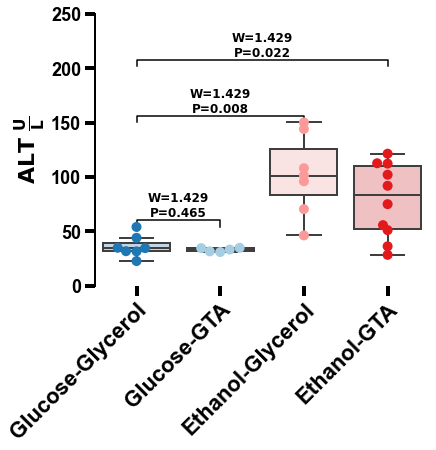

In [141]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 12


fig, ax = plt.subplots(1,1, figsize=(6,5))

# plot
x_axis = 'ALT (u/l)'
phenodf['treatment'] = phenodf['Tx1'] + '-' + phenodf['Tx2'] 
order = ['Glucose-Glycerol', 'Glucose-GTA',
         'Ethanol-Glycerol', 'Ethanol-GTA']
pallette = {'Glucose-Glycerol':'#1f78b4',
         'Glucose-GTA':'#a6cee3',
         'Ethanol-Glycerol':'#fb9a99',
         'Ethanol-GTA':'#e31a1c'}


ax = swarmbox_plot(phenodf, ax,
                    x_axis,
                   'treatment',
                   order,
                   palette=pallette)
# get stats
compare_ = [('Glucose-GTA','Glucose-Glycerol'),
            ('Ethanol-Glycerol','Glucose-Glycerol'),
            ('Ethanol-GTA','Glucose-Glycerol')]

statdf = pd.concat([pd.DataFrame(ranksums(phenodf[phenodf.treatment == c1][x_axis].values,
                                          phenodf[phenodf.treatment == c2][x_axis].values),
                                 ['test-stat', 'P'], ['%s vs. %s' % (c1, c2)]).T
                    for c1, c2 in compare_])
statdf['P'] = multipletests(statdf['P'].values)[1]
max_order = {'%s vs. %s' % (c1, c2):phenodf[phenodf.treatment.isin([c1, c2])][x_axis].max() + (i*40)
             for i, (c1, c2) in enumerate(compare_)}
max_order['Ethanol-Glycerol vs. Glucose-Glycerol'] -= 40

# annotate by order
i1 = 0 
c1 = order[0]
for i2, c2 in enumerate(order[1:]):
    # annot x-axis
    x1, x2 = i1, (i2 + 1)
    # get label
    label_ = c1 + ' vs. ' + c2
    if label_ not in statdf.index:
        label_ = c2 + ' vs. ' + c1
    # get stat
    p_ = statdf.loc[label_, 'P']
    p_ = 'W=%.3f\nP=%.3f' % (t_, p_)
    # heights
    y, h, col = max_order[label_] + .1 * (i2+1), 6, 'k'
    # plot
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            color=col, fontsize=12, weight='bold')
    
# relabel
ax.set_ylabel('ALT $\\frac{\\mathbf{U}}{\\mathbf{L}}$',
              fontsize=22,
              color='black')
ax.tick_params(axis='x', rotation=90)

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(18)
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)

for sp_i in ax.spines.values():
    sp_i.set_linewidth(2)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.spines['left'].set_bounds(0, 250)
ax.set_ylim(0, 250)


# save the figure to file
plt.savefig('results/figures/ALT-GTA.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()
